# Summer Camp Lab 4 - Explainable AI

New this lab:
* Permutation Importance: eli5
* Individual SHAP
  - Force Plot
  - Waterfall Plot
* Aggregate SHAP
  - Bar Plot
  - Summary Plot
  - Dependence Plot
* Permutation Importance: sklearn
* Built-in
  - Random Forest: Gini
  - XGBoost: (Total) Gain   
* Imbalanced Classification



**To work in the notebook, first copy the notebook to your own drive. File > "Save a copy in Drive"**

# Case Study: Wine Quality

**Citation Request**:
  This dataset is publicly available for research and education. The details are described in [Cortez et al., 2009].
  
  *Please include this citation if you plan to use this database.*

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

1. Title: Wine Quality

2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  In the above reference, two datasets were created, using red and white wine samples.
  The inputs include objective tests (e.g. PH values) and the output is based on sensory data
  (median of at least 3 evaluations made by wine experts). Each expert graded the wine quality
  between 0 (very bad) and 10 (very excellent). Several data mining methods were applied to model
  these datasets under a regression approach. The support vector machine model achieved the
  best results. Several metrics were computed: MAD, confusion matrix for a fixed error tolerance (T),
  etc. Also, we plot the relative importances of the input variables (as measured by a sensitivity
  analysis procedure).

4. Relevant Information:

   The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
   For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
   Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables
   are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

   These datasets can be viewed as classification or regression tasks.
   The classes are ordered and not balanced (e.g. there are munch more normal wines than
   excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
   or poor wines. Also, we are not sure if all input variables are relevant. So
   it could be interesting to test feature selection methods.

5. Number of Instances: red wine - 1599; white wine - 4898.

6. Number of Attributes: 11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

7. Attribute information:

   For more information, read [Cortez et al., 2009].

   Input variables (based on physicochemical tests):
   1 - fixed acidity
   2 - volatile acidity
   3 - citric acid
   4 - residual sugar
   5 - chlorides
   6 - free sulfur dioxide
   7 - total sulfur dioxide
   8 - density
   9 - pH
   10 - sulphates
   11 - alcohol
   Output variable (based on sensory data):
   12 - quality (score between 0 and 10)

8. Missing Attribute Values: None

# Setting Up the Workspace

In [ ]:
!pip install shap eli5 imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=61adee94c40a048d3d55a95fab899cc1dada3267ad6f8c317ef6188b7aaa4c8a
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.pipeline import Pipeline

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import shap

import xgboost as xgb

from sklearn.metrics import classification_report

# Loading the Data

In [ ]:
red_wine = pd.read_csv('https://www.dropbox.com/scl/fi/a7cpaeasomjl73qibw1o7/winequality-red.csv?rlkey=mjftqxwd544g6722dzbwxqwoz&dl=1',sep=';').assign(color='red')
white_wine = pd.read_csv('https://www.dropbox.com/scl/fi/a7cpaeasomjl73qibw1o7/winequality-red.csv?rlkey=mjftqxwd544g6722dzbwxqwoz&dl=1',sep=';').assign(color='white')
df = pd.concat([red_wine, white_wine], ignore_index=True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,white
3194,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,white
3195,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,white
3196,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,white


Define target and features

In [ ]:
y = df['quality']
X = df.drop(columns='quality')

In [ ]:
y.value_counts()

5    1362
6    1276
7     398
4     106
8      36
3      20
Name: quality, dtype: int64

# Pipeline

In [ ]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'color'],
      dtype='object')

In [ ]:
#from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
#from sklearn.impute import SimpleImputer
#from sklearn.compose import make_column_transformer, make_column_selector
#from sklearn.pipeline import make_pipeline
#from sklearn.model_selection import train_test_split
#from sklearn import set_config
#from sklearn.pipeline import Pipeline

#Establish each pipeline for different feature types
categorical_features = ['color']
cat_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='most_frequent')), #Impute missing by using the most frequent value along each column
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]) #Encode as one-hot

num_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
num_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer()), #Impute missing values by setting those to the mean value along each column
    #('standardscaler', StandardScaler())
    ]) #Standardize numerical features by removing the mean and scaling to unit variance

#Create rail switch to correctly route each column to the correct pipel
preprocessor = make_column_transformer(
    (cat_pipe, categorical_features),
    (num_pipe, num_features), verbose_feature_names_out=False).set_output(transform="pandas")
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['color']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['fixed acidity', 'volatile acidity',
                                  'citric acid', 'residual sugar', 'chlorides',
                                  'free sulfur dioxide', 'total sulfur dioxide',
                                  'density', 'pH', 'sulphates', 'alcohol'])],
                  verbose_feature_names_out=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
#Transform test test
X_test_preprocessed = preprocessor.transform(X_test)

X_train_preprocessed

,color_red,color_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3034,0.0,1.0,10.2,0.540,0.37,15.4,0.214,55.0,95.0,1.00369,3.18,0.77,9.0
2576,0.0,1.0,8.4,0.590,0.29,2.6,0.109,31.0,119.0,0.99801,3.15,0.50,9.1
533,1.0,0.0,10.3,0.270,0.24,2.1,0.072,15.0,33.0,0.99560,3.22,0.66,12.8
1061,1.0,0.0,9.1,0.400,0.50,1.8,0.071,7.0,16.0,0.99462,3.21,0.69,12.5
2626,0.0,1.0,6.4,0.795,0.00,2.2,0.065,28.0,52.0,0.99378,3.49,0.52,11.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1.0,0.0,9.4,0.400,0.47,2.5,0.087,6.0,20.0,0.99772,3.15,0.50,10.5
1130,1.0,0.0,9.1,0.600,0.00,1.9,0.058,5.0,10.0,0.99770,3.18,0.63,10.4
1294,1.0,0.0,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9
860,1.0,0.0,7.2,0.620,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.5


# Permutation Importance

## eli5

In [ ]:
my_model = RandomForestRegressor(n_estimators=100,
                                  random_state=0).fit(X_train_preprocessed, y_train)

perm = PermutationImportance(my_model, random_state=1).fit(X_train_preprocessed, y_train)
eli5.show_weights(perm, feature_names = X_train_preprocessed.columns.tolist())

Weight,Feature
0.6437 ± 0.0305,alcohol
0.4207 ± 0.0227,sulphates
0.3101 ± 0.0119,volatile acidity
0.1440 ± 0.0113,total sulfur dioxide
0.0836 ± 0.0048,chlorides
0.0622 ± 0.0041,pH
0.0597 ± 0.0018,free sulfur dioxide
0.0529 ± 0.0023,residual sugar
0.0518 ± 0.0020,citric acid
0.0493 ± 0.0028,density


## sklearn

Text(0.5, 0, 'Permutation Importance')

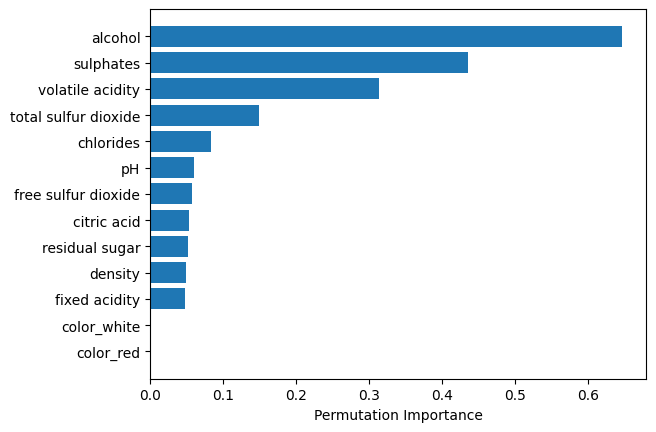

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(my_model, X_train_preprocessed, y_train)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train_preprocessed.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# Built-in XGBoost

## Gain

<Axes: ylabel='feature'>

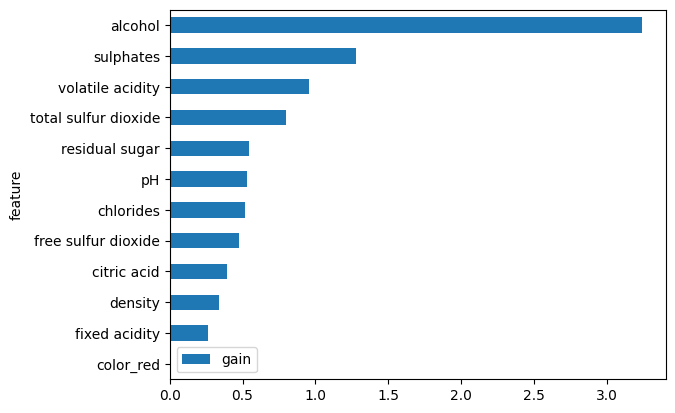

In [ ]:
my_xgb_model = xgb.XGBRegressor(random_state=0).fit(X_train_preprocessed, y_train)

importance_type = 'gain'
feature_important = my_xgb_model.get_booster().get_score(importance_type=importance_type)

data = pd.DataFrame(data=feature_important.items(), columns=["feature", importance_type]).set_index('feature')
data.nsmallest(25, columns=importance_type).plot(kind='barh') ## plot top 25 features

## Total Gain

<Axes: ylabel='feature'>

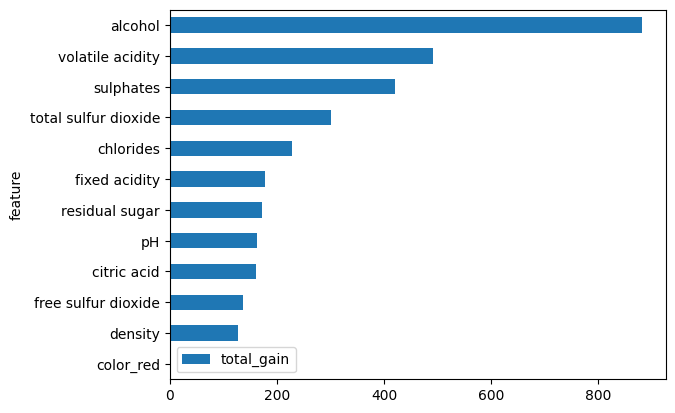

In [ ]:
my_xgb_model = xgb.XGBRegressor(random_state=0).fit(X_train_preprocessed, y_train)

importance_type = 'total_gain'
feature_important = my_xgb_model.get_booster().get_score(importance_type=importance_type)

data = pd.DataFrame(data=feature_important.items(), columns=["feature", importance_type]).set_index('feature')
data.nsmallest(25, columns=importance_type).plot(kind='barh') ## plot top 25 features

# SHAP Values

In [ ]:
#import shap  # package used to calculate Shap values
shap.initjs()

#Create a model
my_model = RandomForestRegressor(n_estimators=100,
                                  random_state=0).fit(X_train_preprocessed, y_train)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of X_test_preprocessed rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_preprocessed)

## Bar Plot

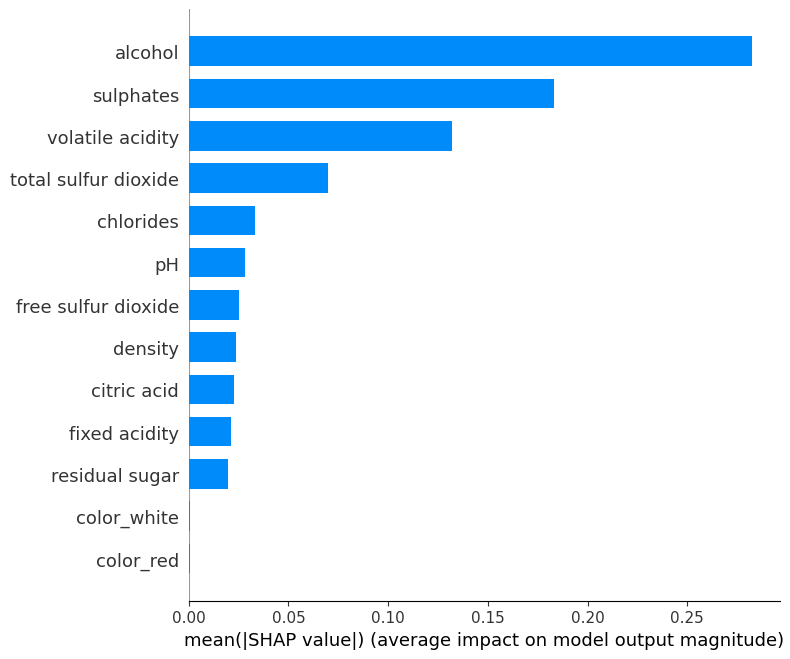

In [ ]:
shap.summary_plot(shap_values, X_test_preprocessed, plot_type='bar')

## Summary Plot

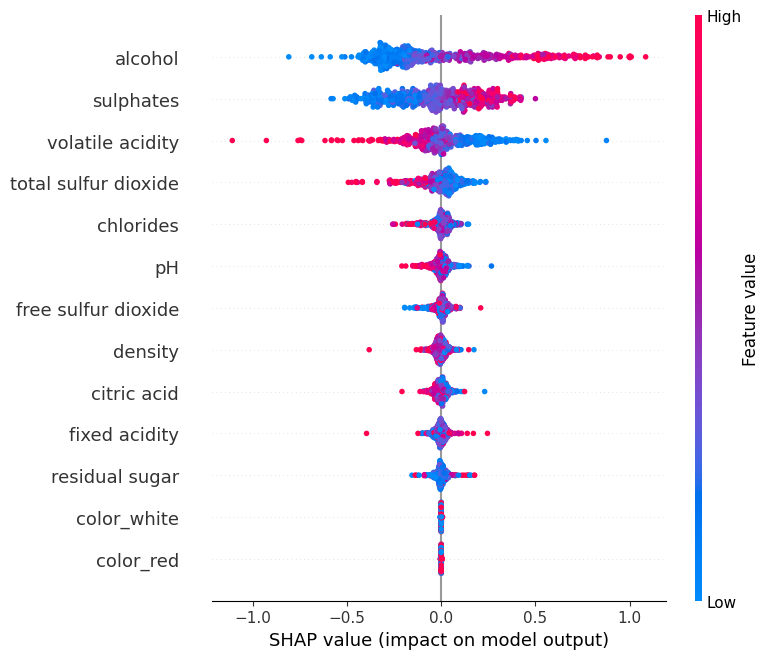

In [ ]:
shap.summary_plot(shap_values, X_test_preprocessed)

<Axes: >

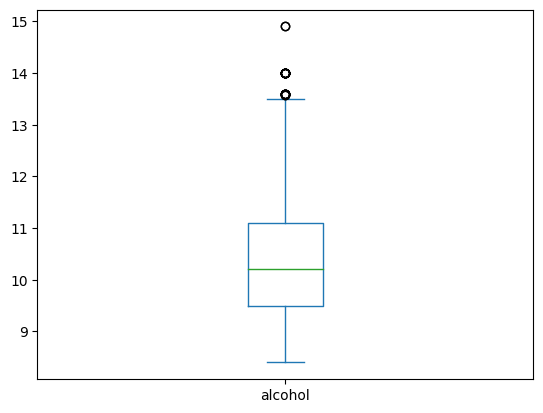

In [ ]:
df.alcohol.plot.box()

## Dependence Plot

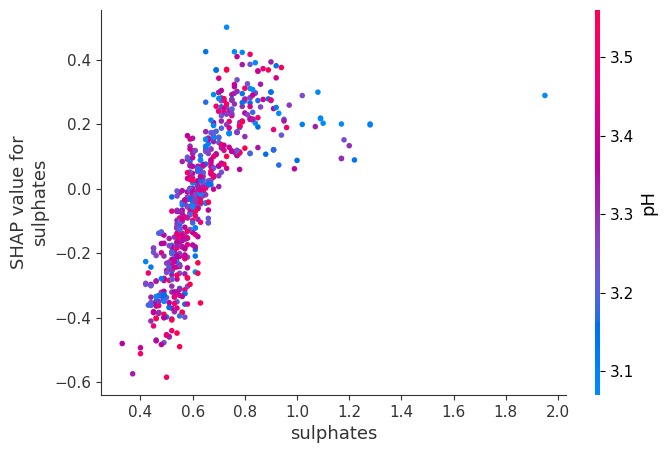

In [ ]:
# make plot.
#https://winefolly.com/deep-dive/sulfites-in-wine/

# Wines with lower acidity need more sulfites than higher acidity wines.
# At pH 3.6 and above, wines are much less stable, and sulfites are necessary for shelf-life.

shap.dependence_plot('sulphates', shap_values, X_test_preprocessed, interaction_index='pH')

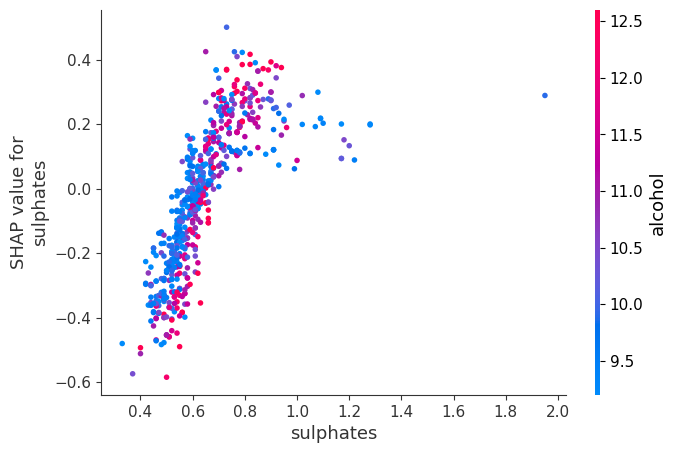

In [ ]:
# make plot.
shap.dependence_plot('sulphates', shap_values, X_test_preprocessed)

## Force Plot

In [ ]:
X_train_preprocessed.reset_index().sort_values(by='alcohol',ascending=False)

,index,color_red,color_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1329,2251,0.0,1.0,15.9,0.36,0.65,7.5,0.096,22.0,71.0,0.99760,2.98,0.84,14.9
1941,652,1.0,0.0,15.9,0.36,0.65,7.5,0.096,22.0,71.0,0.99760,2.98,0.84,14.9
694,1269,1.0,0.0,5.5,0.49,0.03,1.8,0.044,28.0,87.0,0.99080,3.50,0.82,14.0
436,1270,1.0,0.0,5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.70,0.75,14.0
1699,2420,0.0,1.0,4.9,0.42,0.00,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364,2127,0.0,1.0,8.2,0.42,0.49,2.6,0.084,32.0,55.0,0.99880,3.34,0.75,8.7
1241,3035,0.0,1.0,10.0,0.38,0.38,1.6,0.169,27.0,90.0,0.99914,3.15,0.65,8.5
1849,517,1.0,0.0,10.4,0.61,0.49,2.1,0.200,5.0,16.0,0.99940,3.16,0.63,8.4
2018,2143,0.0,1.0,14.3,0.31,0.74,1.8,0.075,6.0,15.0,1.00080,2.86,0.79,8.4


In [ ]:
# Calculate Shap values
shap_explainer_values = explainer(X_train_preprocessed, y_train)

In [ ]:
shap.initjs()
shap.force_plot(shap_explainer_values[1329])

In [ ]:
shap.initjs()
shap.force_plot(shap_explainer_values[694])

In [ ]:
shap.initjs()
shap.force_plot(shap_explainer_values[1550])

In [ ]:
shap.initjs()
shap.force_plot(shap_explainer_values[2018])

## Waterfall Plot

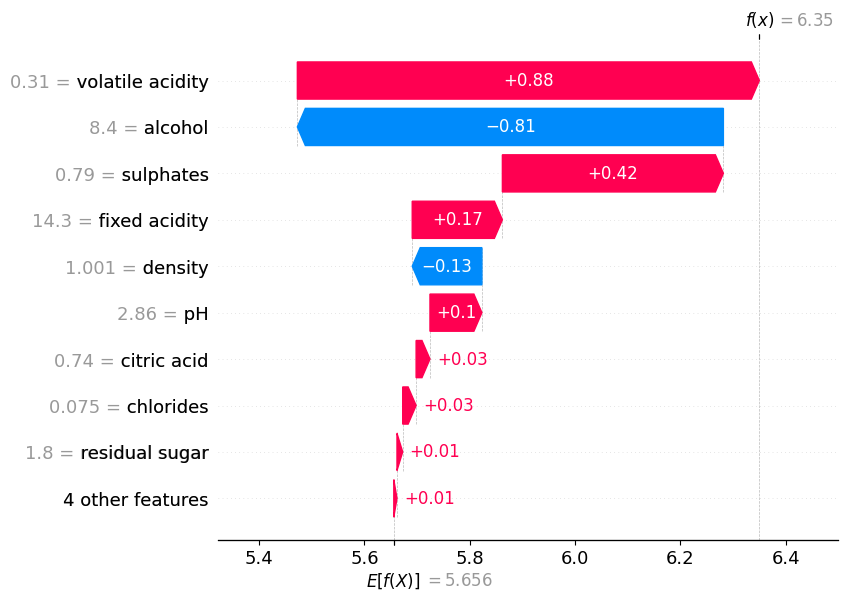

In [ ]:
shap.initjs()
shap.waterfall_plot(shap_explainer_values[2018])

## SHAP values and Classification

When plotting, we call shap_values. For classification problems, there is a separate array of SHAP values for each possible outcome. In that case, we index in to get the SHAP values for the prediction of each class.


In [ ]:
#import shap  # package used to calculate Shap values
shap.initjs()

#Create a model
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(X_train_preprocessed, y_train)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of X_test_preprocessed rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_preprocessed)

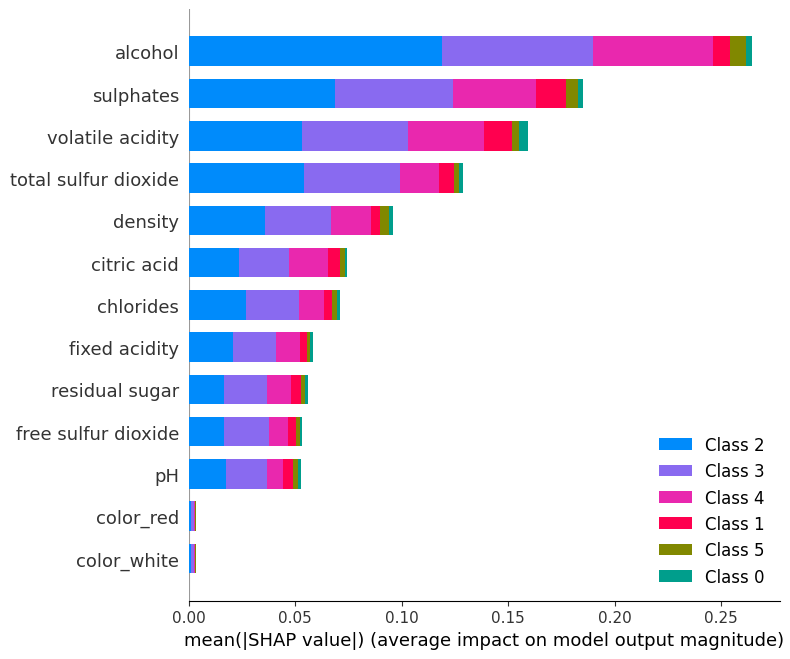

In [ ]:
shap.summary_plot(shap_values, X_test_preprocessed, plot_type='bar')

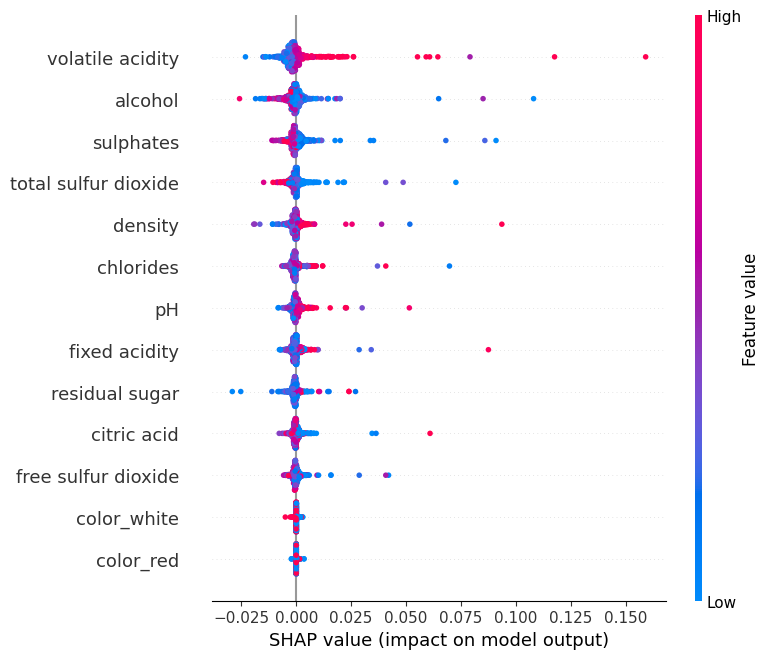

In [ ]:
# For a specific class
shap.summary_plot(shap_values[0], X_test_preprocessed)

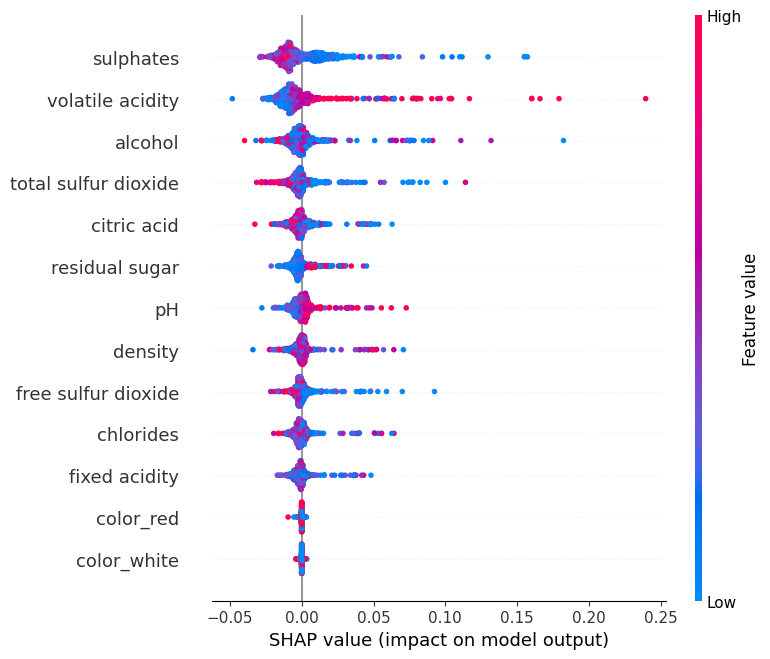

In [ ]:
# For a specific class
shap.summary_plot(shap_values[1], X_test_preprocessed)

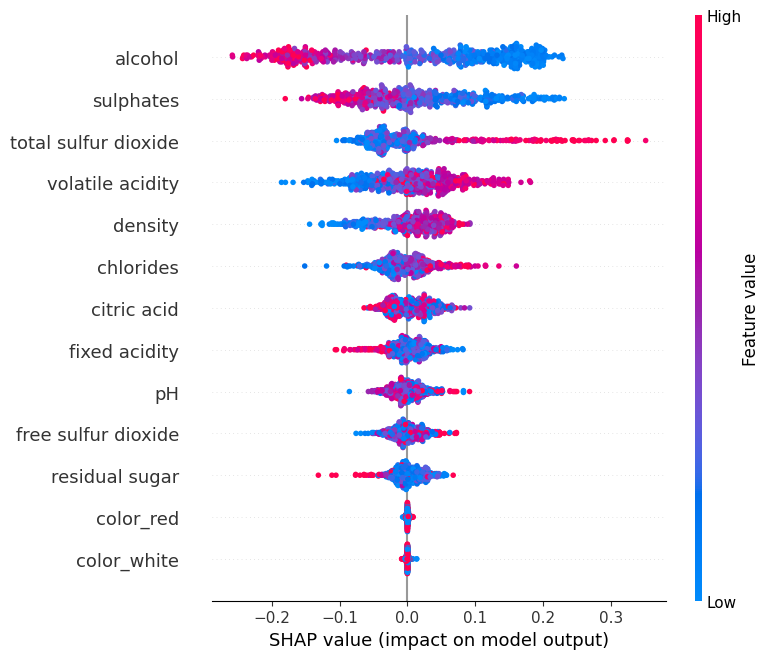

In [ ]:
# For a specific class
shap.summary_plot(shap_values[2], X_test_preprocessed)

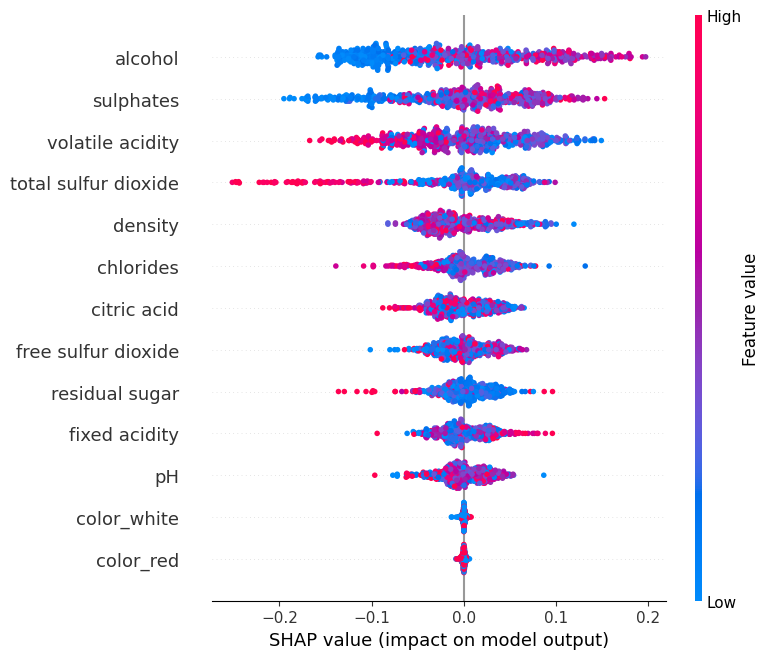

In [ ]:
# For a specific class
shap.summary_plot(shap_values[3], X_test_preprocessed)

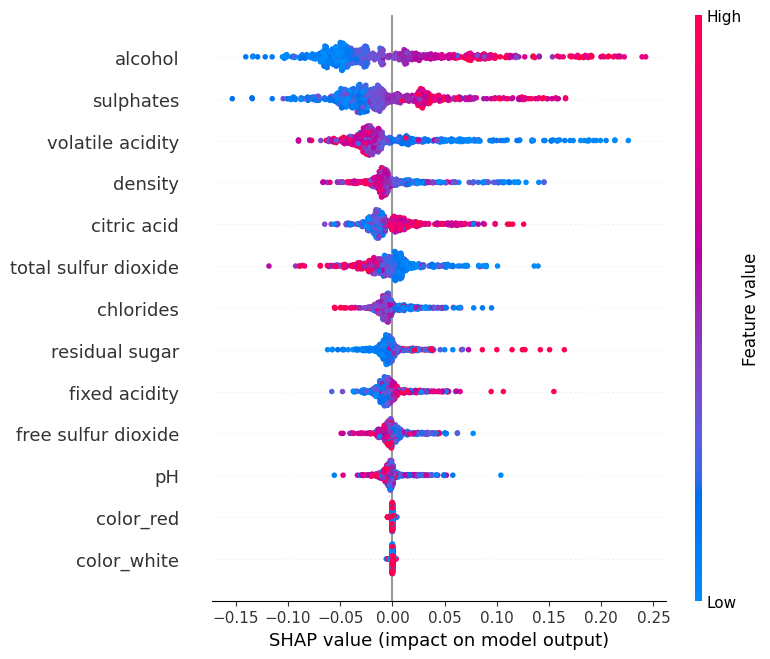

In [ ]:
# For a specific class
shap.summary_plot(shap_values[4], X_test_preprocessed)

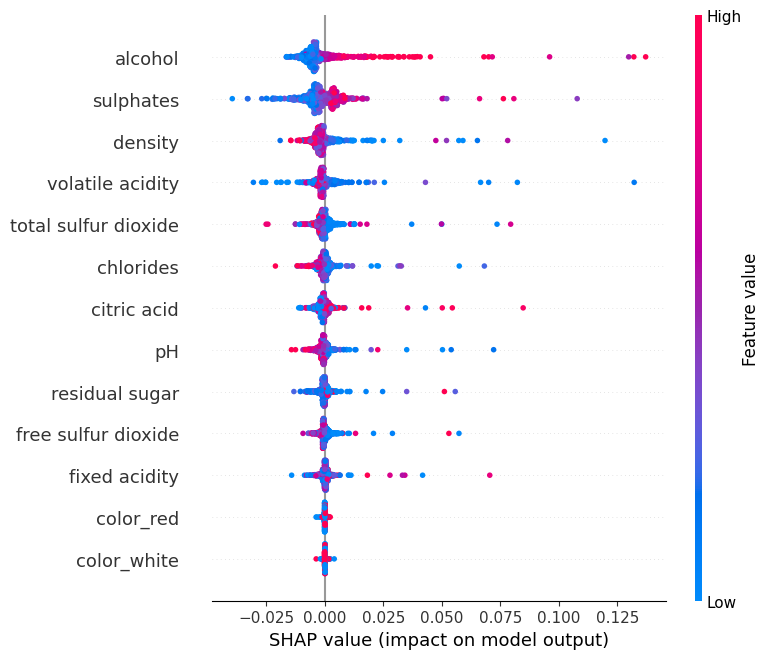

In [ ]:
# For a specific class
shap.summary_plot(shap_values[5], X_test_preprocessed)

 Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small. But you'll want to be careful when running these to plot with reasonably sized datasets. The exception is when using an xgboost model, which SHAP has some optimizations for and which is thus much faster.

# Pipeline with scikit-learn

In [ ]:
my_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                              ('model', RandomForestClassifier(n_estimators=100,
                                  random_state=0))
                             ])

my_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['color']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])],
                                   verbose_feature_names_out=False)),
                ('model', RandomForestClassifier(random_state=0))])

In [ ]:


my_pipeline.fit(X_train, y_train)

y_pred = my_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00         3
           4       0.89      0.62      0.73        26
           5       0.97      0.97      0.97       294
           6       0.94      0.97      0.95       245
           7       1.00      0.97      0.98        67
           8       1.00      1.00      1.00         5

    accuracy                           0.96       640
   macro avg       0.97      0.92      0.94       640
weighted avg       0.96      0.96      0.96       640



# Pipeline with imbalanced-learn for Over- and Undersampling

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


categorical_features = ['color']
imb_cat_pipe = ImbPipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='most_frequent')), #Impute missing by using the most frequent value along each column
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]) #Encode as one-hot

num_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
imb_num_pipe = ImbPipeline(steps=[
    ('simpleimputer', SimpleImputer()), #Impute missing values by setting those to the mean value along each column
    #('standardscaler', StandardScaler())
    ]) #Standardize numerical features by removing the mean and scaling to unit variance

#Create rail switch to correctly route each column to the correct pipel
imb_preprocessor = make_column_transformer(
    (imb_cat_pipe, categorical_features),
    (imb_num_pipe, num_features), verbose_feature_names_out=False).set_output(transform="pandas")
imb_preprocessor


# Bundle preprocessing and modeling code in a pipeline
imb_pipeline = ImbPipeline(steps=[('preprocessor', imb_preprocessor),
                               ('over', SMOTE(random_state=44)),
                               ('under', RandomUnderSampler(random_state=44)),
                              ('model', RandomForestClassifier(n_estimators=100,
                                  random_state=0))
                             ])
                            # Here the Pipeline() function is again like a railway track, with a higer level list of different stations (steps)
                            # Each step is a tuple declaring the name of the step and then the function to apply
imb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['color']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])],
                                   verbose_feature_names_out=False)),
                ('over', SMOTE(random_state=44)),
                ('under', RandomUnderSampler(random_state=44)),
                ('model', RandomForestClassifier(random_state=0))])

In [ ]:
imb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['color']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])],
                                   verbose_feature_names_out=False)),
                ('over', SMOTE(random_state=44)),
                ('under', RandomUnderSampler(random_state=44)),
                ('model', RandomForestClassifier(random_state=0))])

In [ ]:
imb_y_pred = imb_pipeline.predict(X_test)

In [ ]:
# create a list of the labels to describe the classes in the report
print(classification_report(y_test, imb_y_pred))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00         3
           4       0.67      0.62      0.64        26
           5       0.97      0.97      0.97       294
           6       0.96      0.97      0.97       245
           7       1.00      0.97      0.98        67
           8       0.71      1.00      0.83         5

    accuracy                           0.96       640
   macro avg       0.89      0.92      0.90       640
weighted avg       0.96      0.96      0.96       640



# Assignment

1) Practice the following feature importance techniques on your team project data using an XGBoost model:
* Permutation Importance: eli5
* Permutation Importance: sklearn
* Built-in Feature Importance: (Total) Gain
* SHAP Bar Plot
* SHAP Summary Plot
* SHAP Dependence Plot
* Outlier inspection: Force Plot
* Outlier detection: Waterfuall Plot

Do the different techniques yield consistent results? Explain why or why not.

*The goal of the assignment is not to develop an optimal model, but rather to practice your skills and your reasoning!*

Please submit a **PDF summary** of your findings in Canvas, together with your notebook plus link to your notebook.

* Kindly ensure that you share your colab link with the **General access** option selecting in the dropdown menu: **Anyone with the link**  